In [165]:
import os #
import re
import pandas as pd#
import numpy as np #
import multiprocessing as mp #
#from subprocess import Popen, PIPE
#from multiprocessing import Pool
from matplotlib import pyplot as plt #
import statsmodels.stats.multitest as multitest #
from statistics import median
from statistics import mean
from skbio.diversity import alpha_diversity
import skbio.diversity

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
library(ggplot2)

### Let's start

In [3]:
#get_alpha_diversity_shannon based on frequencies
def get_alpha_diversity_shannon(sample_name, path_to_folder_with_sample):
    #------read clonotype tabel
    diversity_shannon_array=[]
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        #total_counts=0
        #clone_counts=0
        local_sample_clone_array=[]
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.split('\t')[1]
            local_sample_clone_array.append(float(clone))
            #total_counts+=1
        diversity_shannon=skbio.diversity.alpha.shannon(local_sample_clone_array, base=2)
   
    diversity_shannon_array.append(diversity_shannon)  
    
    return diversity_shannon_array

In [6]:
#Metadata import
metadata_fmba = pd.read_csv('/projects/fmba_covid/metadata_fmba_full_v2.txt', sep='\t')
metadata_fmba = metadata_fmba.rename(columns={"sample.COVID_status": "COVID_status"})

metadata_AB = pd.read_csv('../../random_forest_v2/AB_prediction/adaptive-metadata-edited.tsv', sep='\t')
metadata_AB["sample_short_name"] = metadata_AB["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names

In [7]:
#Make a cohorts of FMBA
fmba_healthy = set(metadata_fmba.loc[metadata_fmba.COVID_status == 'healthy', "CSP"])
print('fmba_healthy:', len(fmba_healthy))
fmba_IgM_yes = set(metadata_fmba.loc[metadata_fmba['sample.COVID_IgM'] == 'yes', "CSP"])
print('fmba_IgM_yes:', len(fmba_IgM_yes))
fmba_IgM_no_IgG_yes = set(metadata_fmba.loc[(metadata_fmba['sample.COVID_IgM'] == 'no')
                       & (metadata_fmba['sample.COVID_IgG'] == 'yes'), "CSP"])
print('fmba_IgM_no_IgG_yes:', len(fmba_IgM_no_IgG_yes))

#Make a cohorts of Adaptive
AB_acute = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='acute', "sample_short_name")])
print('AB_acute:', len(AB_acute))
AB_recovered = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='recovered', "sample_short_name")])
print('AB_recovered:', len(AB_recovered))
AB_baseline = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='baseline', "sample_short_name")])
print('AB_baseline:', len(AB_baseline))
AB_exposed = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='exposed', "sample_short_name")])
print('AB_exposed:', len(AB_exposed))

#HIP cohort
hip = set([i[: -4] for i in os.listdir('/projects/fmba_covid/hip_full/corr') if i.startswith("HIP")])
print('HIP:', len(hip))
#Keck cohort
Keck = set([i[: -4] for i in os.listdir('/projects/fmba_covid/hip_full/corr') if i.startswith("Keck")])
print('Keck:', len(Keck))

fmba_healthy: 409
fmba_IgM_yes: 410
fmba_IgM_no_IgG_yes: 340
AB_acute: 1140
AB_recovered: 239
AB_baseline: 74
AB_exposed: 26
HIP: 666
Keck: 120


### 1) Find the values of alpha_diversity_shannon for FMBA TRB samples

In [41]:
folder_with_samples="/projects/fmba_covid/fmba_new/corr"
output_file_name="alpha_diversity_shannon_fmba_trb.tsv"
chain="TRB"

#----------read sample names----------
samples=[i for i in os.listdir(folder_with_samples) if i.endswith(f"{chain}.txt")]
#-------------------------------------

def get_alpha_diversity_shannon_wrapper(sample_name, path_to_folder_with_sample=folder_with_samples):
    
    return get_alpha_diversity_shannon(sample_name, path_to_folder_with_sample=path_to_folder_with_sample)



print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_alpha_diversity_shannon_wrapper, samples)
pool.close()
diversity_shannon_in_samples=list(results)
print("DONE")

samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
diversity=pd.DataFrame({'alpha_diversity_shannon': diversity_shannon_in_samples}, index = samples_short_names)
diversity.index.name='sample_name'
diversity.to_csv(output_file_name, sep = '\t')

START
DONE


### 2) Find the values of alpha_diversity_shannon for Adaptive samples

In [42]:
folder_with_samples="/projects/fmba_covid/adaptive_new/corr"
output_file_name="alpha_diversity_shannon_adaptive.tsv"


#----------read sample names----------
samples=os.listdir(folder_with_samples)
#-------------------------------------

def get_alpha_diversity_shannon_wrapper(sample_name, path_to_folder_with_sample=folder_with_samples):
    
    return get_alpha_diversity_shannon(sample_name, path_to_folder_with_sample=path_to_folder_with_sample)



print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_alpha_diversity_shannon_wrapper, samples)
pool.close()
diversity_shannon_in_samples=list(results)
print("DONE")

samples_short_names = list(map(lambda x: x[: -13], samples))  
diversity=pd.DataFrame({'alpha_diversity_shannon': diversity_shannon_in_samples}, index = samples_short_names)
diversity.index.name='sample_name'
diversity.to_csv(output_file_name, sep = '\t')

START
DONE


### 3) Find the values of alpha_diversity_shannon for HIP, Keck samples

In [43]:
folder_with_samples="/projects/fmba_covid/hip_full/corr"
output_file_name="alpha_diversity_shannon_hip_keck.tsv"


#----------read sample names----------
samples=os.listdir(folder_with_samples)
#-------------------------------------

def get_alpha_diversity_shannon_wrapper(sample_name, path_to_folder_with_sample=folder_with_samples):
    
    return get_alpha_diversity_shannon(sample_name, path_to_folder_with_sample=path_to_folder_with_sample)



print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_alpha_diversity_shannon_wrapper, samples)
pool.close()
diversity_shannon_in_samples=list(results)
print("DONE")

samples_short_names = list(map(lambda x: x[: -4], samples))   
diversity=pd.DataFrame({'alpha_diversity_shannon': diversity_shannon_in_samples}, index = samples_short_names)
diversity.index.name='sample_name'
diversity.to_csv(output_file_name, sep = '\t')

START
DONE


In [44]:
#concat dataframes
a=pd.read_csv('alpha_diversity_shannon_fmba_trb.tsv', sep='\t', index_col=0)
b=pd.read_csv('alpha_diversity_shannon_adaptive.tsv', sep='\t', index_col=0)
c=pd.read_csv('alpha_diversity_shannon_hip_keck.tsv', sep='\t',  index_col=0)
output_file_name="alpha_diversity_shannon_all_cohorts.tsv"


all_data=pd.concat([a, b, c], axis=0)

#Make a column with cohorts
all_data['cohorts'] = 'FMBA_healthy'
all_data.loc[set(all_data.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
all_data.loc[set(all_data.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'
all_data.loc[set(all_data.index.values)&AB_acute, 'cohorts'] = 'AB_acute'
all_data.loc[set(all_data.index.values)&AB_recovered, 'cohorts'] = 'AB_recovered'
all_data.loc[set(all_data.index.values)&AB_exposed, 'cohorts'] = 'AB_exposed'
all_data.loc[set(all_data.index.values)&hip, 'cohorts'] = 'HIP'
all_data.loc[set(all_data.index.values)&Keck, 'cohorts'] = 'Keck'
#fmba_healthy: 409
#fmba_IgM_yes: 410
#fmba_IgM_no_IgG_yes: 340
#AB_acute: 1140
#AB_recovered: 239
#AB_baseline: 74
#AB_exposed: 26
#HIP: 666
#Keck: 120
all_data['alpha_diversity_shannon'] = all_data['alpha_diversity_shannon'].map(lambda x: float(x[1:-1]))
#all_data.apply(lambda x: x[1:-1], index='alpha_diversity_shannon', axis=1)
all_data.to_csv(output_file_name, sep = '\t')

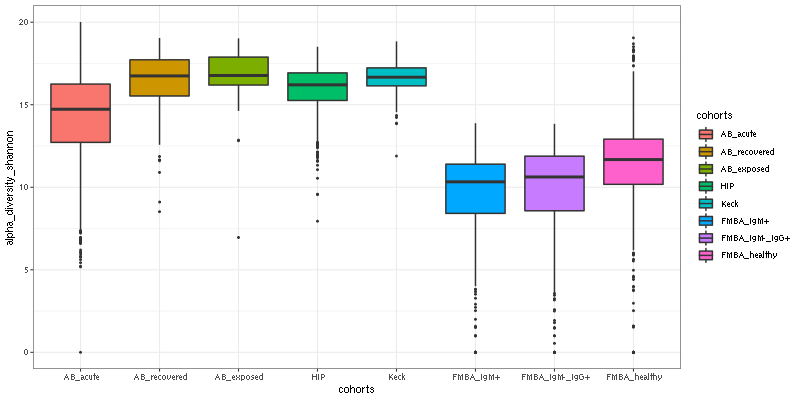

In [37]:
%%R -w 800 -h 400
all_data=read.csv('alpha_diversity_shannon_all_cohorts.tsv', sep="\t", header=TRUE)
all_data$cohorts=factor(all_data$cohorts,
                        levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                 "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))

ggplot(all_data, aes(x=cohorts, y=alpha_diversity_shannon, fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

### Find the correlation between the number of reads and the frequency of features

In [197]:
def get_mean_count_and_feat_freq(sample_name, path_to_folder_with_sample, clones_for_analyse):
    #------read clonotype tabel
    mean_count_dict={"mean_count": 0, "feature_frequency": 0}
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        total_counts=0
        #clone_counts=0
        local_sample_count_array=[]
        local_sample_clone_array=[]
        for clone in clonotype_file.readlines()[1:]: #skip header
            count=clone.split('\t')[0]
            clone=clone.split('\t')[3]
            local_sample_count_array.append(float(count))
            local_sample_clone_array.append(clone)
            total_counts+=1
        if total_counts>=treshold:   
            #medi=skbio.diversity.alpha.chao1(local_sample_count_array, bias_corrected=True)
            mean_count=mean(local_sample_count_array)
            #medi=skbio.diversity.alpha.shannon(local_sample_count_array, base=2)
            founded_features=set(local_sample_clone_array)&set(clones_for_analyse)
            total_freq = len(founded_features)/(total_counts*10)
     
            mean_count_dict.update({"mean_count":float(mean_count)})
            mean_count_dict.update({"feature_frequency":float(total_freq)})
            
        else:
            mean_count_dict.update({"mean_count":np.nan})
            mean_count_dict.update({"feature_frequency":np.nan})
    
        return mean_count_dict

In [54]:
#import associated clones
associated_clones_fmba = pd.read_csv('../../fmba/COVID_status_TRB_fmba_full_v2_pv.txt', sep='\t')
associated_clones_fmba = list(associated_clones_fmba.cdr3aa)[:1000]

associated_clones_AB = pd.read_csv('../../adaptive/covid_status_top.txt', sep='\t')
associated_clones_AB = list(associated_clones_AB.cdr3aa)[:1000]

associated_clones_AB_FMBA = pd.read_csv("../graph_leven_distance/incidence_of_features_AB_vs_FMBA_sorted.tsv", sep = '\t', index_col=0)
associated_clones_AB_FMBA=list(associated_clones_AB_FMBA.index.values) 
associated_clones_AB_FMBA=[x for x in associated_clones_AB_FMBA if '_' not in x]
associated_clones_AB_FMBA=associated_clones_AB_FMBA[:1000]

associated_clones_fmba_trb_ttest=pd.read_csv("../../fmba/FMBA_TRB_sign_clones_ttest_top2000.tsv", sep="\t",index_col=0)
associated_clones_fmba_trb_ttest=list(associated_clones_fmba_trb_ttest.index.values)[:1000]

associated_clones_fmba_tra_ttest=pd.read_csv("../../fmba/FMBA_TRA_sign_clones_ttest_top2000.tsv", sep="\t",index_col=0)
associated_clones_fmba_tra_ttest=list(associated_clones_fmba_tra_ttest.index.values)[:1000]

#associated_clones_fmba_tra_fisher=pd.read_csv("../../fmba/COVID_status_TRA_fmba_full_v2_pv.txt", sep="\t",index_col=0)
#associated_clones_fmba_tra_fisher=list(associated_clones_fmba_tra_fisher.index.values)[:200]

#### 1) Features FMBA(TRB) T-test

#### 1.1) FMBA samples

In [199]:
%%time
treshold=100
folder_with_samples="/projects/fmba_covid/fmba_new/corr"
output_file_name="correlation_of_reads_number_and_feature_freq/reads_number_and_feature_freq_fmba.tsv"
clones_for_analyse=associated_clones_fmba_trb_ttest  
chain="TRB"

#----------read sample names----------
samples=[i for i in os.listdir(folder_with_samples) if i.endswith(f"{chain}.txt")]

def get_mean_count_and_feat_freq_wrapper(sample_name, 
                                        path_to_folder_with_sample=folder_with_samples, cones_for_analyse=clones_for_analyse):
    
    return get_mean_count_and_feat_freq(sample_name, 
                                       path_to_folder_with_sample=path_to_folder_with_sample, clones_for_analyse=clones_for_analyse)



print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_mean_count_and_feat_freq_wrapper, samples)
pool.close()
read_num_and_ffreq_in_samples=results
print("DONE")

samples_short_names=list(map(lambda x: int(x[:12]), samples)) 
read_num_and_ffreq=pd.DataFrame(read_num_and_ffreq_in_samples, index = samples_short_names)
read_num_and_ffreq.index.name='sample_name'
read_num_and_ffreq=read_num_and_ffreq.dropna()
read_num_and_ffreq.to_csv(output_file_name, sep = '\t')

START
DONE
CPU times: user 513 ms, sys: 3.11 s, total: 3.62 s
Wall time: 3.94 s


#### 1.2) Adaptive samples

In [201]:
%%time
treshold=100
folder_with_samples="/projects/fmba_covid/adaptive_new/corr"
output_file_name="correlation_of_reads_number_and_feature_freq/reads_number_and_feature_freq_adaptive.tsv"
clones_for_analyse=associated_clones_fmba_trb_ttest  
#chain="TRB"

#----------read sample names----------
samples=os.listdir(folder_with_samples)
samples_short_names = list(map(lambda x: x[: -13], samples)) 

def get_mean_count_and_feat_freq_wrapper(sample_name, 
                                        path_to_folder_with_sample=folder_with_samples, cones_for_analyse=clones_for_analyse):
    
    return get_mean_count_and_feat_freq(sample_name, 
                                       path_to_folder_with_sample=path_to_folder_with_sample, clones_for_analyse=clones_for_analyse)



print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_mean_count_and_feat_freq_wrapper, samples)
pool.close()
read_num_and_ffreq_in_samples=results
print("DONE")


read_num_and_ffreq=pd.DataFrame(read_num_and_ffreq_in_samples, index = samples_short_names)
read_num_and_ffreq.index.name='sample_name'
read_num_and_ffreq=read_num_and_ffreq.dropna()
read_num_and_ffreq.to_csv(output_file_name, sep = '\t')

START
DONE
CPU times: user 1.68 s, sys: 11 s, total: 12.7 s
Wall time: 42 s


#### 1.3) HIP/Keck samples

In [202]:
%%time
treshold=100
folder_with_samples="/projects/fmba_covid/hip_full/corr"
output_file_name="correlation_of_reads_number_and_feature_freq/reads_number_and_feature_freq_hip_keck.tsv"
clones_for_analyse=associated_clones_fmba_trb_ttest  
#chain="TRB"

#----------read sample names----------
samples=os.listdir(folder_with_samples)
samples_short_names = list(map(lambda x: x[: -4], samples))    

def get_mean_count_and_feat_freq_wrapper(sample_name, 
                                        path_to_folder_with_sample=folder_with_samples, cones_for_analyse=clones_for_analyse):
    
    return get_mean_count_and_feat_freq(sample_name, 
                                       path_to_folder_with_sample=path_to_folder_with_sample, clones_for_analyse=clones_for_analyse)



print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_mean_count_and_feat_freq_wrapper, samples)
pool.close()
read_num_and_ffreq_in_samples=results
print("DONE")


read_num_and_ffreq=pd.DataFrame(read_num_and_ffreq_in_samples, index = samples_short_names)
read_num_and_ffreq.index.name='sample_name'
read_num_and_ffreq=read_num_and_ffreq.dropna()
read_num_and_ffreq.to_csv(output_file_name, sep = '\t')

START
DONE
CPU times: user 4.38 s, sys: 29.2 s, total: 33.6 s
Wall time: 2min 12s


Text(0, 0.5, 'Feature frequency')

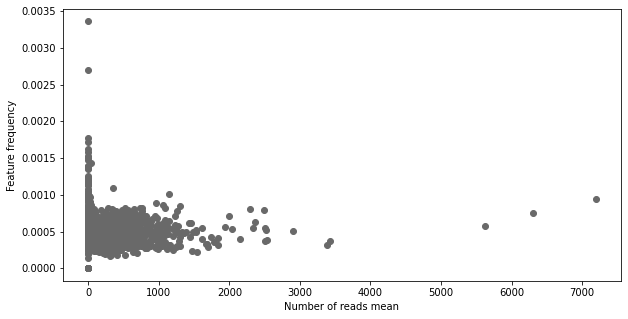

In [203]:
read_num_and_ffreq=pd.read_csv("correlation_of_reads_number_and_feature_freq/reads_number_and_feature_freq_fmba.tsv", sep='\t')
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(x=list(read_num_and_ffreq.mean_count), y=list(read_num_and_ffreq.feature_frequency), c="dimgray")
plt.xlabel("Number of reads mean")
plt.ylabel("Feature frequency")

Text(0, 0.5, 'Feature frequency')

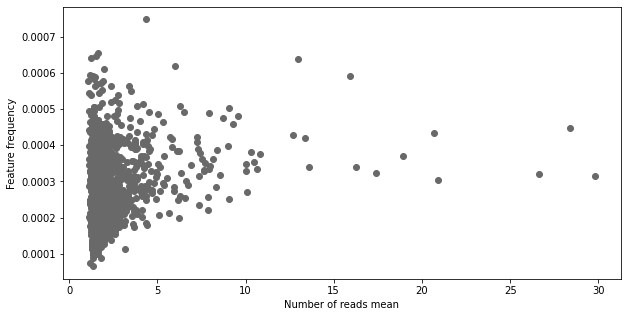

In [205]:
read_num_and_ffreq=pd.read_csv("correlation_of_reads_number_and_feature_freq/reads_number_and_feature_freq_adaptive.tsv", sep='\t')
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(x=list(read_num_and_ffreq.mean_count), y=list(read_num_and_ffreq.feature_frequency), c="dimgray")
plt.xlabel("Number of reads mean")
plt.ylabel("Feature frequency")

Text(0, 0.5, 'Feature frequency')

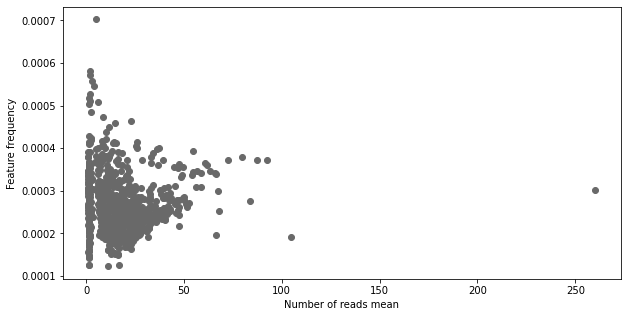

In [206]:
read_num_and_ffreq=pd.read_csv("correlation_of_reads_number_and_feature_freq/reads_number_and_feature_freq_hip_keck.tsv", sep='\t')
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(x=list(read_num_and_ffreq.mean_count), y=list(read_num_and_ffreq.feature_frequency), c="dimgray")
plt.xlabel("Number of reads mean")
plt.ylabel("Feature frequency")

### Find the values of alpha_diversity_chao

In [207]:
#get_alpha_diversity_chao 
def get_alpha_diversity_chao(sample_name, path_to_folder_with_sample):
    #------read clonotype tabel
    diversity_chao_array=0
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        total_counts=0
        #clone_counts=0
        local_sample_clone_array=[]
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.split('\t')[0]
            local_sample_clone_array.append(float(clone))
            total_counts+=1
        if total_counts>=treshold:
            diversity_chao=skbio.diversity.alpha.chao1(local_sample_clone_array, bias_corrected=True)
   
            diversity_chao_array=diversity_chao
        else: 
            diversity_chao_array=np.nan 
    
    return diversity_chao_array

In [ ]:
folder_with_samples="/projects/fmba_covid/fmba_new/corr"
output_file_name="alpha_diversity_shannon_fmba_trb.tsv"
chain="TRB"

#----------read sample names----------
samples=[i for i in os.listdir(folder_with_samples) if i.endswith(f"{chain}.txt")]
#-------------------------------------

def get_alpha_diversity_shannon_wrapper(sample_name, path_to_folder_with_sample=folder_with_samples):
    
    return get_alpha_diversity_shannon(sample_name, path_to_folder_with_sample=path_to_folder_with_sample)



print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_alpha_diversity_shannon_wrapper, samples)
pool.close()
diversity_shannon_in_samples=list(results)
print("DONE")

samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
diversity=pd.DataFrame({'alpha_diversity_shannon': diversity_shannon_in_samples}, index = samples_short_names)
diversity.index.name='sample_name'
diversity.to_csv(output_file_name, sep = '\t')